In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import metrics
import joblib
import datetime
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import sys
# sys.path.append(r"source/model_source")
from model.PNet import LSTM, NN, PSiameseNetwork, DatasetUtil, ContrastiveLoss 

n_days_lookahead = int(input('Please input the length of days lookahead in {5, 7, 15, 30, 45, 60, 90, 120}: '))

if(n_days_lookahead not in [5, 7, 15, 30, 45, 60, 90, 120]):
    print('Input does not meet requirements.')
    exit()

data_type = str(input('Please specify the coverage of the data {A - Manufacturer 1, B - Manufacturer 2, C - Manufacturer 1 & 2, D - Unbalanced}: '))

if(data_type not in ['A', 'B', 'C', 'D']):
    print('Input does not meet requirements.')
    exit()

dit_str = {'A': 'mc1', 'B': 'mc2', 'C': 'mc1_mc2', 'D': 'unbalanced'}

model_type = str(input('Please input the type of trained model to use {A - Manufacturer 1, B - Manufacturer 2, C - Manufacturer 1 & 2, D - Unbalanced}: '))

if(model_type not in ['A', 'B', 'C', 'D']):
    print('Input does not meet requirements.')
    exit()

def loadData():

    X = np.load('../data/' + dit_str[data_type] + '/' + str(n_days_lookahead) + '_days_lookahead/smart_test.npy',allow_pickle=True)
    y = np.load('../data/' + dit_str[data_type] + '/' + str(n_days_lookahead) + '_days_lookahead/test_labels.npy',allow_pickle=True)
    aging = np.load('../data/aging.npy', allow_pickle = True)


    X = X.astype('float32')
    y = y.astype('float32')
    aging = aging.astype('float32')
    return X.reshape((len(X),30,-1)), y, aging

def get_all_metrics(true, predicted, score):
    print(metrics.classification_report(true, predicted, digits=5))
    print(metrics.confusion_matrix(true, predicted))
    print('auc', metrics.roc_auc_score(true, score))
    
def decision(x_smart, aging, model):
    # ret val: 0(unhealthy) 1(healthy)    
    with torch.no_grad():
        out1, out2 = model(x_smart, aging)
#         print(out1, out2)
        # print(F.pairwise_distance(out1, out2, p=2))
#         print(out1.shape, out2.shape)
        distance = F.pairwise_distance(out1, out2, p=2)
#         print(distance.shape)
#         distance = [F.pairwise_distance(x1, x2, p=2) for (x1,x2) in zip(out1, out2)]
    return distance

def computeScore(distance, limit):
    if distance>1:
        return 0.01
    elif distance<limit:
        return float(1-distance/limit*0.5)
    else: 
        return float(1-(0.5+(distance-limit)/(1-limit)*0.5))
    
import pandas as pd    
def saveExcel(data, path):
    data_df = pd.DataFrame(data) 
    writer = pd.ExcelWriter(path)
    data_df.to_excel(writer,'page_1') 
    writer.save()
    pass


/usr/local/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Please input the length of days lookahead in {5, 7, 15, 30, 45, 60, 90, 120}:  5
Please specify the coverage of the data {A - Manufacturer 1, B - Manufacturer 2, C - Manufacturer 1 & 2, D - Manufacturer 1 without aging information}:  A
Please input the type of trained model to use {A - Manufacturer 1, B - Manufacturer 2, C - Manufacturer 1 & 2, D - Manufacturer 1 without aging information}:  A


cuda
(9652, 30, 11)
------------------ Pnet ------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

         0.0    0.82763   0.82677   0.82720      4826
         1.0    0.82695   0.82781   0.82738      4826

    accuracy                        0.82729      9652
   macro avg    0.82729   0.82729   0.82729      9652
weighted avg    0.82729   0.82729   0.82729      9652

[[3990  836]
 [ 831 3995]]
auc 0.896548649745499
0.896548649745499


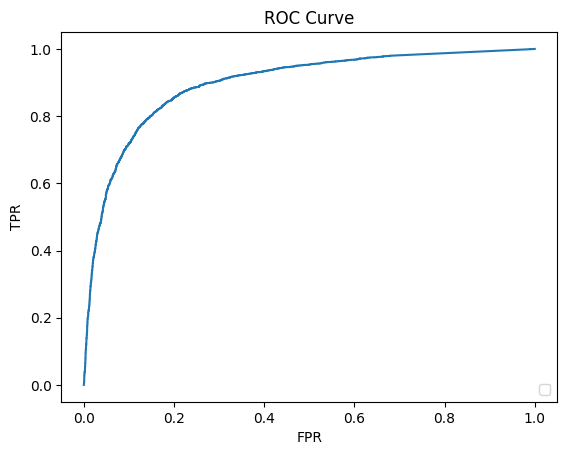

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size_smart = 330
hidden_size_smart = 128

output_size_smart = 48
input_size_aging = 5
hidden_size_aging = 32
output_size_aging = 48
output_size_model = 64
num_layers_smart = 3
num_layers_aging = 3
pnet = PSiameseNetwork(
    input_size_smart=input_size_smart, 
    input_size_aging=input_size_aging, 
    hidden_size_smart=hidden_size_smart, 
    hidden_size_aging=hidden_size_aging,
    num_layers_smart=num_layers_smart, 
    num_layers_aging=num_layers_aging,
    output_size_smart=output_size_smart, 
    output_size_aging=output_size_aging,
    output_size_model=output_size_model
)
pnet.load_state_dict(torch.load('../trained_model/' + dit_str[model_type] + '/' + str(n_days_lookahead) + '_days_lookahead/pnet.pth'))

X_smart_test, y_smart_test, aging = loadData()
print(X_smart_test.shape)

test_dataset_smart = DatasetUtil(X_smart_test, aging, y_smart_test)
test_loader_smart = DataLoader(dataset=test_dataset_smart, batch_size=128, shuffle=False)

print('------------------ Pnet ------------------')
y_pred_list = []
y_score_list = []
y_true_list = []
with torch.no_grad():
    for i, (X, aging, y) in enumerate(test_loader_smart):
        X = X.to(device)
        y = y.to(device)
        aging = aging.to(device)
        distance = decision(X, aging, pnet)
        
        for j in range(0,len(distance)):
            score = computeScore(distance[j], 0.51)
            y_score_list.append(score)
            y_pred_list.append(1 if distance[j]<=0.51 else 0)            
            y_true_list.append(y[j].cpu().numpy()[0])
            
get_all_metrics(np.asarray(y_true_list), np.asarray(y_pred_list), np.asarray(y_score_list))
# print(y_true_list)
fpr_apsnet, tpr_apsnet, thersholds = roc_curve(np.asarray(y_true_list), np.asarray(y_score_list))
roc_auc = auc(fpr_apsnet, tpr_apsnet)

print(roc_auc)
plt.plot(fpr_apsnet, tpr_apsnet)
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()